# The Success Equation: Skill + Effort + (More Than You Think) Luck - A Walkthrough Analysis

This notebook provides a walkthrough of our analysis on the role of luck in success, inspired by a Veritasium video (link). We explore this concept through simulations of a selection process, like astronaut selection, where both skill and luck play a role.

## 1. Importing Libraries
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

## 2. Defining the Simulation Function

The `astronaut_simulation` function simulates the selection process. It takes the number of applicants, number selected, weights for skill and luck, number of simulations, and distribution of scores as input.
___

In [2]:
def astronaut_simulation(num_applicants=18300, num_selected=200, luck_weight=0.05, num_simulations=1000, distribution='uniform', loc=85, scale=10):
    """Simulates a selection process based on skill and luck.

    This function simulates a scenario where applicants are evaluated based on a combination of skill and luck.
    It calculates the average luck score of the selected applicants, the average number of top-skilled applicants selected,
    and the average impact of luck on the selection process.

    Args:
        num_applicants (int, optional): The total number of applicants. Defaults to 18300.
        num_selected (int, optional): The number of applicants to be selected. Defaults to 200.
        luck_weight (float, optional): The weight given to luck in the overall score calculation (between 0 and 1). Defaults to 0.05.
        num_simulations (int, optional): The number of simulation runs. Defaults to 1000.
        distribution (str, optional): The distribution to use for generating skill and luck scores ('uniform' or 'normal'). Defaults to 'uniform'.
        loc (int, optional): The mean (location) of the normal distribution (used only if distribution is 'normal'). Defaults to 85.
        scale (int, optional): The standard deviation (scale) of the normal distribution (used only if distribution is 'normal'). Defaults to 10.

    Returns:
        tuple: A tuple containing three lists:
            - avg_luck_scores (list): A list of average luck scores for the selected applicants in each simulation.
            - avg_top_skill_selected (list): A list of the number of top-skilled applicants selected in each simulation.
            - impact_of_luck_measures (list): A list of the impact of luck on the selection in each simulation (as a proportion).

    Raises:
        ValueError: If the distribution is not 'uniform' or 'normal'.
    """
    impact_of_luck_measures = []
    avg_luck_scores = []
    avg_top_skill_selected = []
    skill_weight = 1-luck_weight
    for _ in range(num_simulations):
        if distribution == 'uniform':
            skill_scores = np.random.randint(0, 101, num_applicants)
            luck_scores = np.random.randint(0, 101, num_applicants)
        elif distribution == 'normal':
            skill_scores = np.clip(np.random.normal(loc, scale, num_applicants), 0, 100).astype(int)
            luck_scores = np.clip(np.random.normal(loc, scale, num_applicants), 0, 100).astype(int)
        else:
            raise ValueError("Distribution must be either 'normal' or 'uniform'")
        overall_scores = (skill_weight * skill_scores) + (luck_weight * luck_scores)

        selected_indices = np.argsort(overall_scores)[::-1][:num_selected]
        top_skill_indices = np.argsort(skill_scores)[::-1][:num_selected]
        avg_luck_scores.append(np.mean(luck_scores[selected_indices]))
        top_skill_selected_count = len(set(selected_indices) & set(top_skill_indices))
        avg_top_skill_selected.append(top_skill_selected_count)
        impact_of_luck_measures.append(1 - top_skill_selected_count / num_selected)

    return avg_luck_scores, avg_top_skill_selected, impact_of_luck_measures

## 3. Running a Basic Simulation

Let's run a simulation with default parameters and analyze the results.
___

In [3]:
num_applicants=3000
num_selected=10
luck_weight=0.05
num_simulations=1_000
distribution = 'uniform'
avg_luck_scores, avg_top_skill_selected, impact_of_luck = astronaut_simulation(
    num_applicants, num_selected, luck_weight, num_simulations, distribution
)

print(f"Average luck score of selected astronauts: {np.mean(avg_luck_scores):.1f}")
print(f"Average number of top-skilled astronauts selected: {np.mean(avg_top_skill_selected):.1f}")
print(f"Average impact of luck: {np.mean(impact_of_luck):.2%}")

Average luck score of selected astronauts: 88.7
Average number of top-skilled astronauts selected: 2.7
Average impact of luck: 73.22%


## 4. Distribution Plots

Visualizing the distributions of average luck scores, number of top-skilled selected, and impact of luck.
___

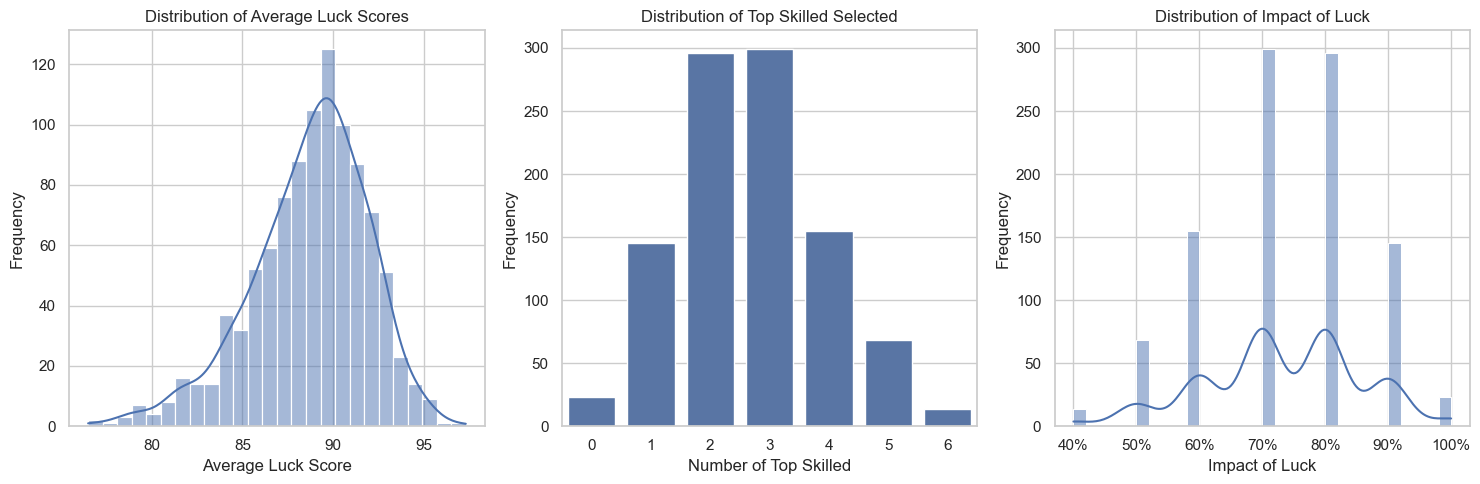

In [4]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.histplot(avg_luck_scores, kde=True)
plt.title('Distribution of Average Luck Scores')
plt.xlabel('Average Luck Score')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
sns.countplot(x=avg_top_skill_selected)
plt.title('Distribution of Top Skilled Selected')
plt.xlabel('Number of Top Skilled')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
sns.histplot(impact_of_luck, kde=True)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title(f'Distribution of Impact of Luck')
plt.xlabel('Impact of Luck')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Impact of Luck Weight

Analyzing how the impact of luck changes with different luck weights.
___

C:\Users\Utilisateur\anaconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Utilisateur\anaconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


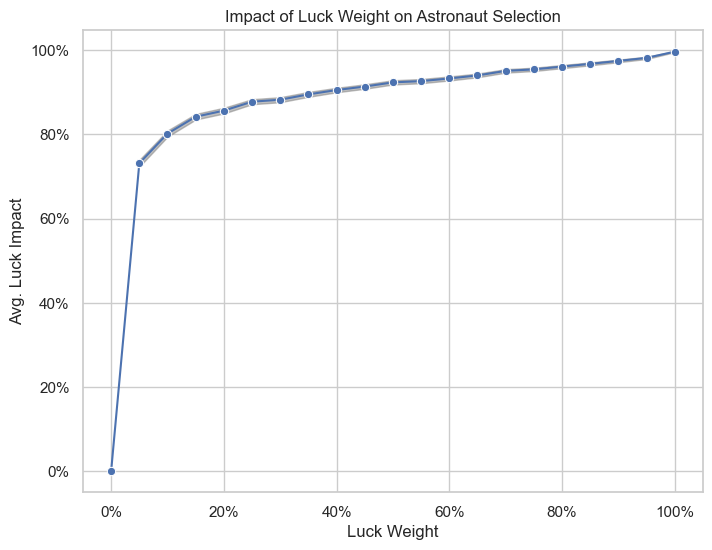

In [5]:
luck_weights = np.linspace(0.0, 1.0, 21)
results = []
for weight in luck_weights:
    _, _, impact = astronaut_simulation(
        num_applicants, num_selected, weight, num_simulations, distribution
    )
    mean_impact = np.mean(impact)
    std_err = stats.sem(impact)
    confidence_interval = stats.t.interval(0.95, len(impact)-1, loc=mean_impact, scale=std_err)
    results.append({'Luck Weight': weight,
                    'Luck Impact': mean_impact,
                    'Lower bound': confidence_interval[0],
                    'Upper bound': confidence_interval[1]})

df_results = pd.DataFrame(results)

plt.figure(figsize=(8,6))
a = sns.lineplot(x='Luck Weight', y='Luck Impact', data=df_results, marker='o')
b = sns.lineplot(x='Luck Weight', y='Lower bound', data=df_results, linestyle='')
c = sns.lineplot(x='Luck Weight', y='Upper bound', data=df_results, linestyle='')
line = a.get_lines()
plt.fill_between(line[0].get_xdata()[1:], line[1].get_ydata(), line[2].get_ydata(), color='grey', alpha=.5)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel("Luck Weight")
plt.ylabel("Avg. Luck Impact")
plt.title("Impact of Luck Weight on Astronaut Selection")
plt.grid(True)
plt.show()

## 6. Impact of Selection Ratio

Investigating the relationship between the selection ratio (selected/applicants) and the impact of luck.
___

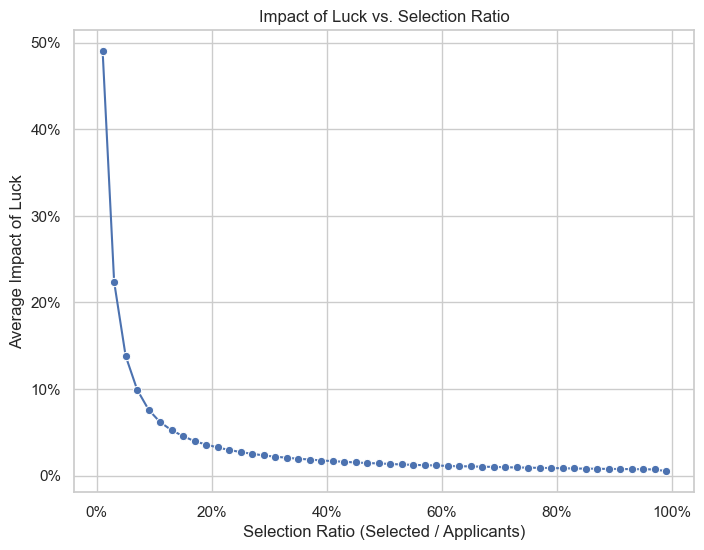

In [6]:
ratios = np.linspace(0.01, 0.99, 50)
num_applicants = 1000
impact_of_luck_results = []

for ratio in ratios:
    num_selected = int(num_applicants * ratio)
    if num_selected == 0:
        continue
    _, _, impact_of_luck_measures = astronaut_simulation(num_applicants, num_selected, luck_weight, num_simulations, distribution)
    impact_of_luck_results.append({'Ratio': ratio, 'Impact of Luck': np.mean(impact_of_luck_measures)})

df_results = pd.DataFrame(impact_of_luck_results)

plt.figure(figsize=(8,6))
sns.lineplot(x='Ratio', y='Impact of Luck', data=df_results, marker='o')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('Selection Ratio (Selected / Applicants)')
plt.ylabel('Average Impact of Luck')
plt.title('Impact of Luck vs. Selection Ratio')
plt.grid(True)
plt.show()

## 7. Interactive Web App

For a more interactive exploration, we have also created a Streamlit web app that allows you to vary the simulation parameters and visualize the results in real-time.

[Try it here.]()

## 8. Conclusion

This analysis demonstrates the significant role luck can play in outcomes, even when skill and effort are major contributing factors. Our simulations, based on a simplified model of a selection process like astronaut selection, highlight several key insights:

*   **The Impact of Luck is Not Constant:** Luck's influence is not uniform across all situations. It is significantly amplified in highly competitive scenarios with low selection ratios (i.e., when many people are competing for few positions).
*   **Luck Weight Matters:** As expected, increasing the weight given to luck in the selection process directly increases its overall impact. However, the interaction with the selection ratio persists: even with a high luck weight, a high selection ratio can mitigate its effects.
*   **The Success Paradox:** While it is crucial to believe in the power of hard work and skill to motivate effort, it is equally important to acknowledge the role of luck. This apparent contradiction—the "success paradox"—highlights the need for both drive and humility. Overestimating one's control can lead to a sense of entitlement and a lack of empathy for those who face greater challenges or less fortunate circumstances.

These findings have implications for how we view success and failure:

*   **Humility and Gratitude:** Recognizing the role of luck can foster humility and gratitude for the opportunities and circumstances that have contributed to our achievements.
*   **Empathy and Understanding:** Understanding the impact of luck can increase our empathy for others who may not have achieved the same level of success, even with comparable talent and effort.
*   **System Design:** These insights can inform the design of fairer systems that minimize the influence of chance and maximize opportunities for all individuals, regardless of their background or circumstances.

By understanding the interplay of skill, effort, and luck, we can develop a more nuanced and realistic perspective on success, leading to greater self-awareness, empathy, and a commitment to creating more equitable opportunities.
